## Лабораторная работа №2

**Цель - познакомиться с методом кластеризации K-mean с помощью пакета sklearn.**

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("data.csv")

print("Первые 5 строк датасета:")
print(df.head())

print(f"\nРазмер датасета: {df.shape}")
print("\nИнформация о столбцах:")
print(df.info())

Первые 5 строк датасета:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_wors

### Добавление новых атрибутов
Новые атрибуты: seismic_energy - nuclear_abnormality_index - взвешенная мера аномальности ядра клетки, compactness_ratio - мера компактности формы ядра клетки

In [109]:
df['diagnosis_numeric'] = df['diagnosis'].map({'B': 0, 'M': 1})
diagnosis_correlations = df[['radius_mean', 'concavity_mean', 'concave points_mean', 
                            'perimeter_mean', 'area_mean', 'texture_mean']].corrwith(df['diagnosis_numeric']).abs()

print("КОРРЕЛЯЦИИ ПРИЗНАКОВ С ДИАГНОЗОМ:")
for feature, corr in diagnosis_correlations.sort_values(ascending=False).items():
    print(f"  {feature}: {corr:.3f}")

correlation_weights = diagnosis_correlations / diagnosis_correlations.sum()
print(f"\nВЕСА НА ОСНОВЕ КОРРЕЛЯЦИЙ:")
for feature, weight in correlation_weights.sort_values(ascending=False).items():
    print(f"  {feature}: {weight:.3f} ({weight*100:.1f}%)")

df['nuclear_abnormality_index'] = sum(df[feature] * weight for feature, weight in correlation_weights.items())

df['compactness_ratio'] = df['area_mean'] / (df['perimeter_mean'] + 1e-8)

print("Новые атрибуты добавлены:")
print(df[['radius_mean', 'concavity_mean', 'nuclear_abnormality_index', 
          'compactness_ratio']].head(10))

print(f"\nИнтервалы значений новых атрибутов:")
print(f"nuclear_abnormality_index: {df['nuclear_abnormality_index'].min():.2f}-{df['nuclear_abnormality_index'].max():.2f}")
print(f"compactness_ratio: {df['compactness_ratio'].min():.2f}-{df['compactness_ratio'].max():.2f}")

КОРРЕЛЯЦИИ ПРИЗНАКОВ С ДИАГНОЗОМ:
  concave points_mean: 0.777
  perimeter_mean: 0.743
  radius_mean: 0.730
  area_mean: 0.709
  concavity_mean: 0.696
  texture_mean: 0.415

ВЕСА НА ОСНОВЕ КОРРЕЛЯЦИЙ:
  concave points_mean: 0.191 (19.1%)
  perimeter_mean: 0.182 (18.2%)
  radius_mean: 0.179 (17.9%)
  area_mean: 0.174 (17.4%)
  concavity_mean: 0.171 (17.1%)
  texture_mean: 0.102 (10.2%)
Новые атрибуты добавлены:
   radius_mean  concavity_mean  nuclear_abnormality_index  compactness_ratio
0        17.99         0.30010                 201.153168           8.151466
1        20.57         0.08690                 260.778567           9.977427
2        19.69         0.19740                 239.049169           9.253846
3        11.42         0.24140                  85.606160           4.976798
4        20.29         0.19800                 255.753426           9.600296
5        12.45         0.15780                 102.057813           5.778128
6        18.25         0.11270                 

### Предобработка датасета

In [110]:
print("Информация о данных:")
print(df.info())

print("\nПроверка пропущенных значений:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

if missing_values.sum() == 0:
    print("Пропущенных значений нет!")

print("\nПроверка дубликатов:")
duplicates = df.duplicated().sum()
print(f"Количество дубликатов: {duplicates}")

df = df.drop('Unnamed: 32', axis=1, errors='ignore')

print(f"\nРазмер датасета после удаления Unnamed: 32: {df.shape}")

df = df.drop('id', axis=1, errors='ignore')

print(f"Размер датасета после удаления id: {df.shape}")

# Проверка на выбросы с использованием межквартильного размаха
def check_outliers(df, columns):
    outlier_info = []
    for col in columns:
        if df[col].dtype in ['float64', 'int64']:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
            outlier_info.append({
                'feature': col,
                'outliers': outliers,
                'percentage': (outliers / len(df)) * 100
            })
    return pd.DataFrame(outlier_info)

key_features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 
                'smoothness_mean', 'compactness_mean', 'concavity_mean', 
                'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
                'nuclear_abnormality_index', 'compactness_ratio']

outliers_report = check_outliers(df, key_features)
print("\nАнализ выбросов в ключевых признаках:")
print(outliers_report[outliers_report['outliers'] > 0])

print("\nЯ решил не удалять выбросы, так как они могут представлять клинически важные случаи")

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         569 non-null    int64  
 1   diagnosis                  569 non-null    object 
 2   radius_mean                569 non-null    float64
 3   texture_mean               569 non-null    float64
 4   perimeter_mean             569 non-null    float64
 5   area_mean                  569 non-null    float64
 6   smoothness_mean            569 non-null    float64
 7   compactness_mean           569 non-null    float64
 8   concavity_mean             569 non-null    float64
 9   concave points_mean        569 non-null    float64
 10  symmetry_mean              569 non-null    float64
 11  fractal_dimension_mean     569 non-null    float64
 12  radius_se                  569 non-null    float64
 13  texture_se                 56

### Визуализация данных и поиск кластеров

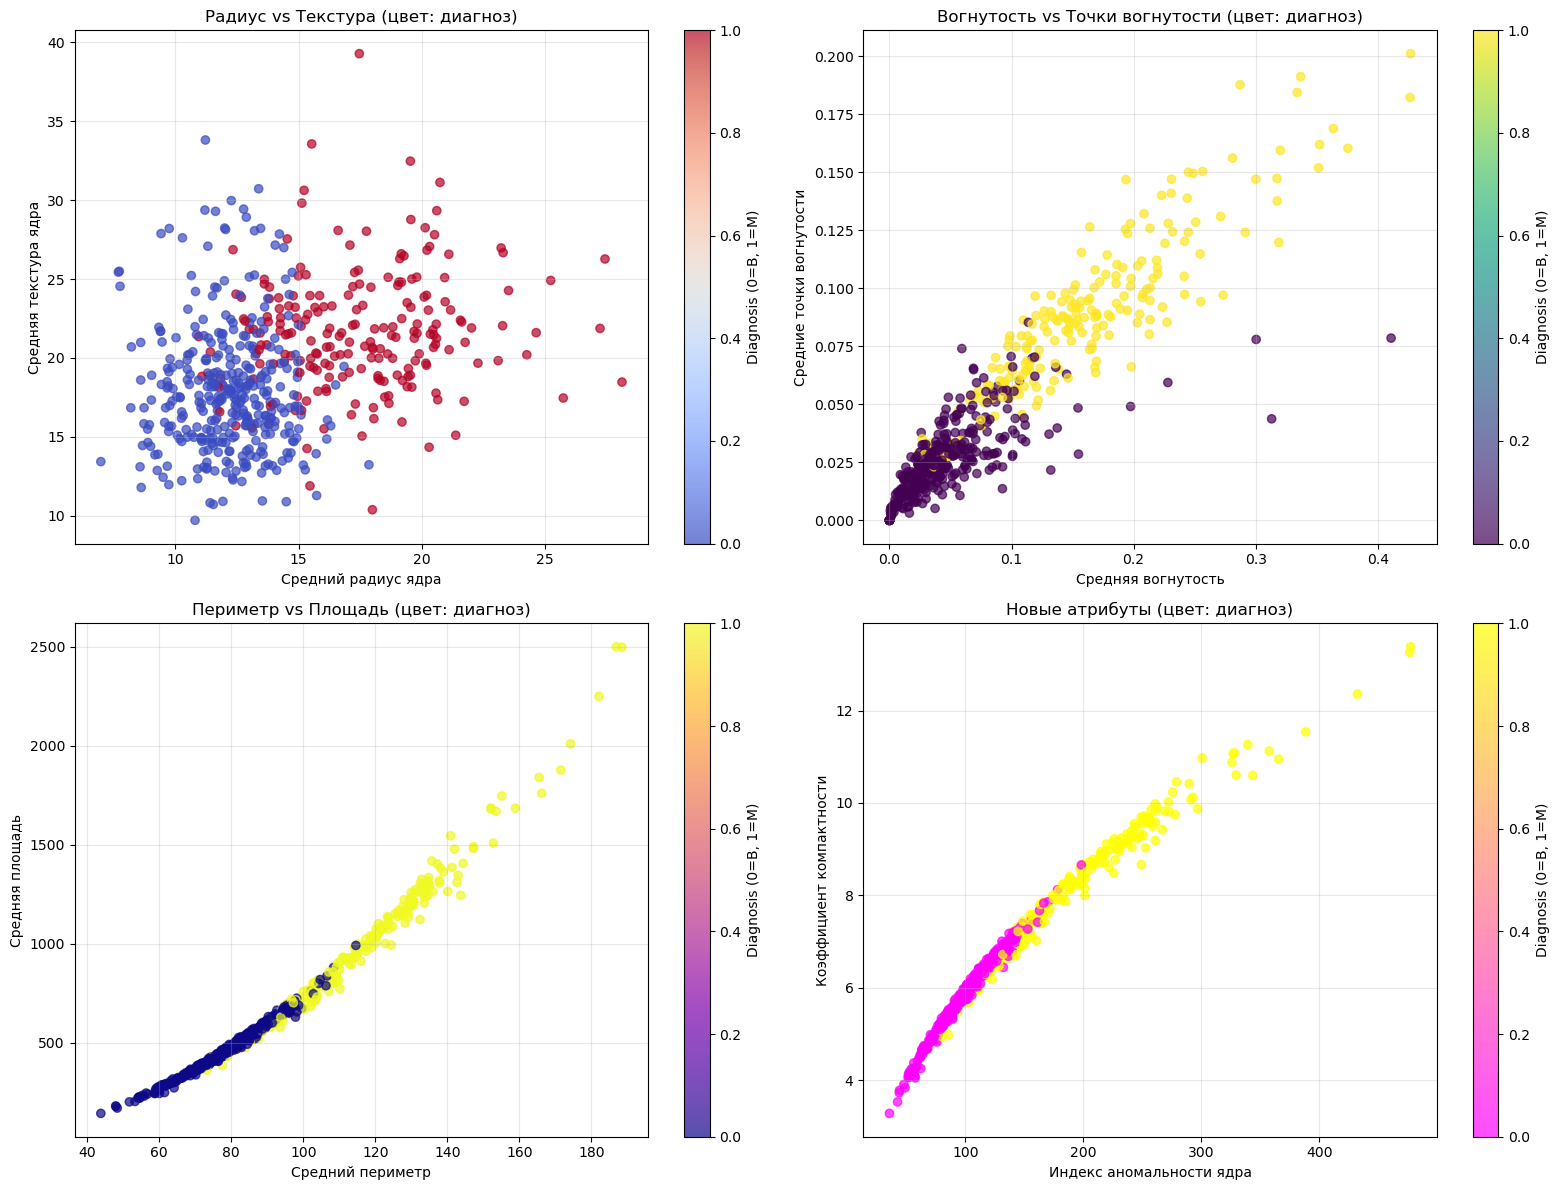

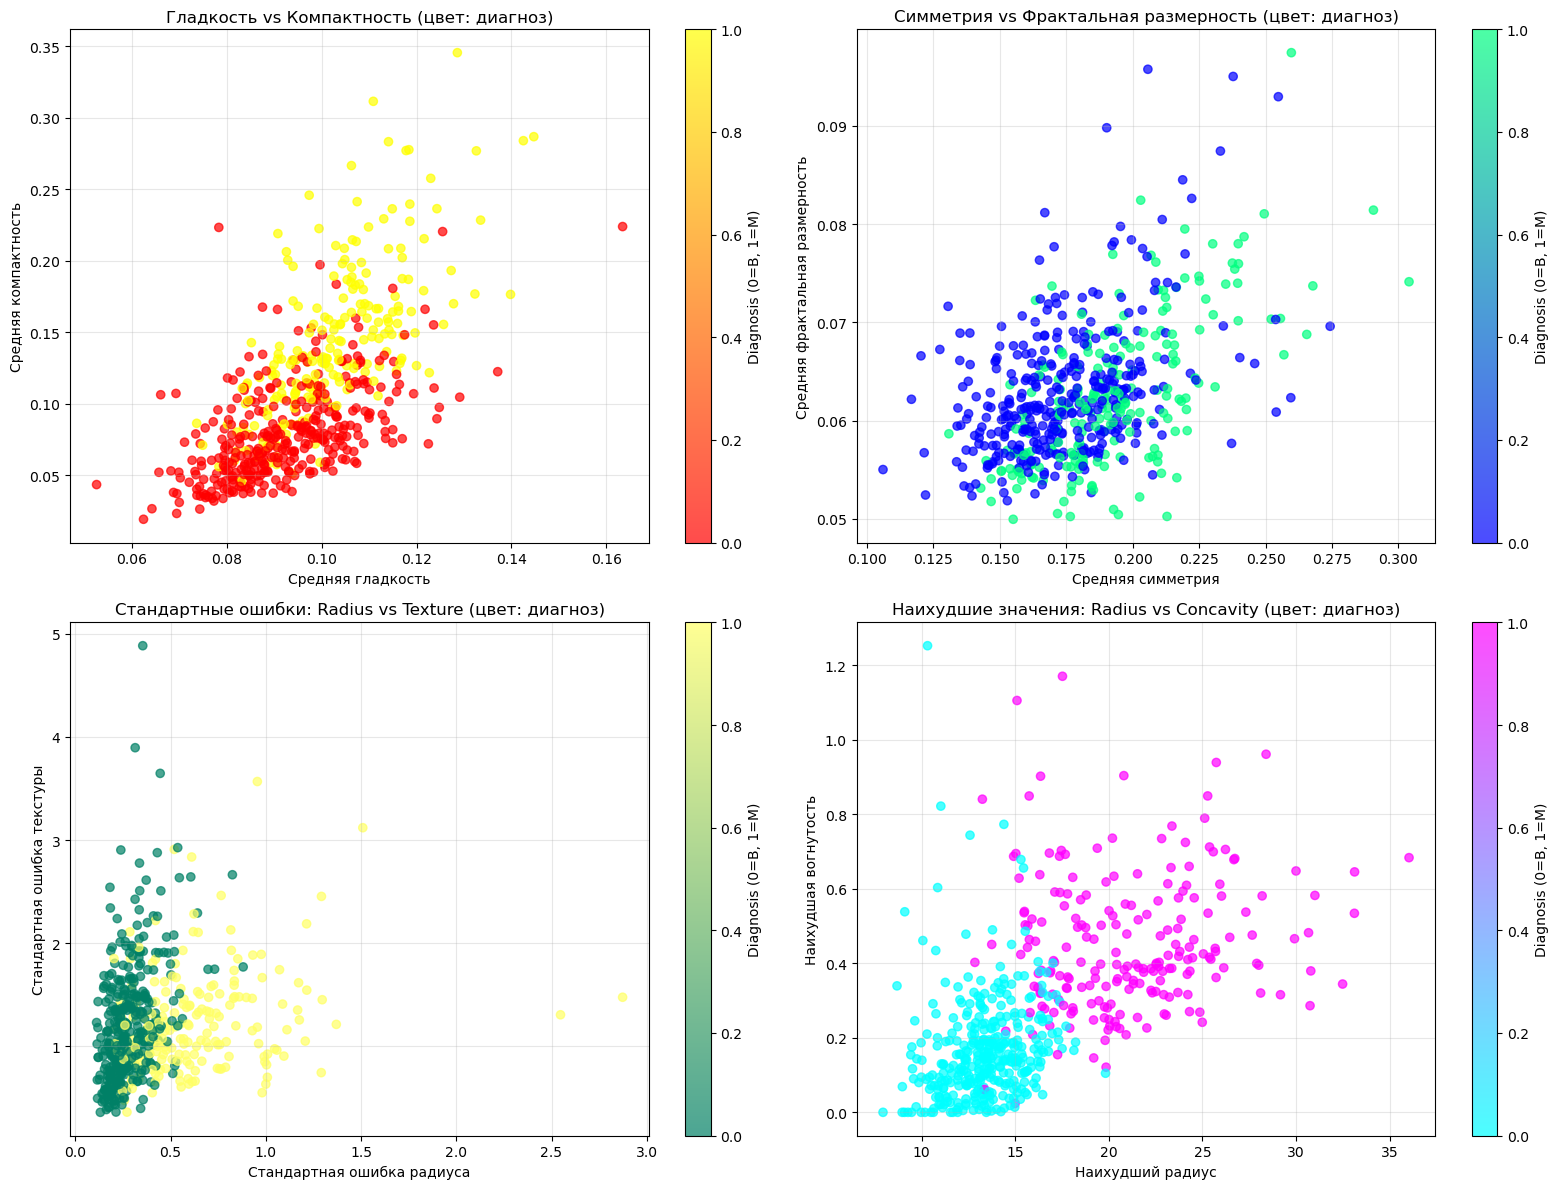

In [111]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

scatter1 = axes[0,0].scatter(df['radius_mean'], df['texture_mean'], 
                            c=df['diagnosis_numeric'], cmap='coolwarm', alpha=0.7)
axes[0,0].set_xlabel('Средний радиус ядра')
axes[0,0].set_ylabel('Средняя текстура ядра')
axes[0,0].set_title('Радиус vs Текстура (цвет: диагноз)')
axes[0,0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0,0], label='Diagnosis (0=B, 1=M)')

scatter2 = axes[0,1].scatter(df['concavity_mean'], df['concave points_mean'], 
                            c=df['diagnosis_numeric'], cmap='viridis', alpha=0.7)
axes[0,1].set_xlabel('Средняя вогнутость')
axes[0,1].set_ylabel('Средние точки вогнутости')
axes[0,1].set_title('Вогнутость vs Точки вогнутости (цвет: диагноз)')
axes[0,1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[0,1], label='Diagnosis (0=B, 1=M)')

scatter3 = axes[1,0].scatter(df['perimeter_mean'], df['area_mean'], 
                            c=df['diagnosis_numeric'], cmap='plasma', alpha=0.7)
axes[1,0].set_xlabel('Средний периметр')
axes[1,0].set_ylabel('Средняя площадь')
axes[1,0].set_title('Периметр vs Площадь (цвет: диагноз)')
axes[1,0].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[1,0], label='Diagnosis (0=B, 1=M)')

scatter4 = axes[1,1].scatter(df['nuclear_abnormality_index'], df['compactness_ratio'], 
                            c=df['diagnosis_numeric'], cmap='spring', alpha=0.7)
axes[1,1].set_xlabel('Индекс аномальности ядра')
axes[1,1].set_ylabel('Коэффициент компактности')
axes[1,1].set_title('Новые атрибуты (цвет: диагноз)')
axes[1,1].grid(True, alpha=0.3)
plt.colorbar(scatter4, ax=axes[1,1], label='Diagnosis (0=B, 1=M)')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

scatter1 = axes[0,0].scatter(df['smoothness_mean'], df['compactness_mean'], 
                            c=df['diagnosis_numeric'], cmap='autumn', alpha=0.7)
axes[0,0].set_xlabel('Средняя гладкость')
axes[0,0].set_ylabel('Средняя компактность')
axes[0,0].set_title('Гладкость vs Компактность (цвет: диагноз)')
axes[0,0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0,0], label='Diagnosis (0=B, 1=M)')

scatter2 = axes[0,1].scatter(df['symmetry_mean'], df['fractal_dimension_mean'], 
                            c=df['diagnosis_numeric'], cmap='winter', alpha=0.7)
axes[0,1].set_xlabel('Средняя симметрия')
axes[0,1].set_ylabel('Средняя фрактальная размерность')
axes[0,1].set_title('Симметрия vs Фрактальная размерность (цвет: диагноз)')
axes[0,1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[0,1], label='Diagnosis (0=B, 1=M)')

scatter3 = axes[1,0].scatter(df['radius_se'], df['texture_se'], 
                            c=df['diagnosis_numeric'], cmap='summer', alpha=0.7)
axes[1,0].set_xlabel('Стандартная ошибка радиуса')
axes[1,0].set_ylabel('Стандартная ошибка текстуры')
axes[1,0].set_title('Стандартные ошибки: Radius vs Texture (цвет: диагноз)')
axes[1,0].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[1,0], label='Diagnosis (0=B, 1=M)')

scatter4 = axes[1,1].scatter(df['radius_worst'], df['concavity_worst'], 
                            c=df['diagnosis_numeric'], cmap='cool', alpha=0.7)
axes[1,1].set_xlabel('Наихудший радиус')
axes[1,1].set_ylabel('Наихудшая вогнутость')
axes[1,1].set_title('Наихудшие значения: Radius vs Concavity (цвет: диагноз)')
axes[1,1].grid(True, alpha=0.3)
plt.colorbar(scatter4, ax=axes[1,1], label='Diagnosis (0=B, 1=M)')

plt.tight_layout()
plt.show()

### Кластеризация методом KMeans

In [112]:
features_for_clustering = [col for col in df.columns if '_mean' in col] + \
                         ['nuclear_abnormality_index', 'compactness_ratio']

print(f"Признаков для кластеризации: {len(features_for_clustering)}")
print("Признаки:", features_for_clustering)

X = df[features_for_clustering]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nРазмерность данных после масштабирования: {X_scaled.shape}")

Признаков для кластеризации: 12
Признаки: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'nuclear_abnormality_index', 'compactness_ratio']

Размерность данных после масштабирования: (569, 12)


### Определение оптимального количества кластеров

Расчет метрик для разных K:
K = 2: Inertia = 3968.37, Silhouette Score = 0.416
K = 3: Inertia = 3211.87, Silhouette Score = 0.329
K = 4: Inertia = 2811.76, Silhouette Score = 0.227
K = 5: Inertia = 2457.74, Silhouette Score = 0.232
K = 6: Inertia = 2259.64, Silhouette Score = 0.204
K = 7: Inertia = 2115.08, Silhouette Score = 0.206
K = 8: Inertia = 1979.25, Silhouette Score = 0.208
K = 9: Inertia = 1842.97, Silhouette Score = 0.199


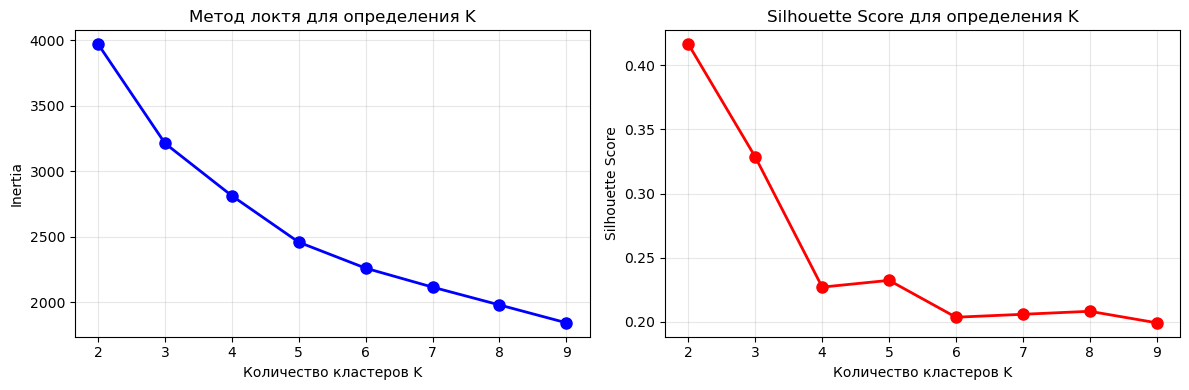


Оптимальное количество кластеров: 2 (на основе Silhouette Score)


In [113]:
inertia = []
silhouette_scores = []
k_range = range(2, 10)

print("Расчет метрик для разных K:")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_
    inertia.append(kmeans.inertia_)
    
    silhouette_avg = silhouette_score(X_scaled, labels)
    silhouette_scores.append(silhouette_avg)
    print(f"K = {k}: Inertia = {kmeans.inertia_:.2f}, Silhouette Score = {silhouette_avg:.3f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Количество кластеров K')
plt.ylabel('Inertia')
plt.title('Метод локтя для определения K')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Количество кластеров K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score для определения K')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nОптимальное количество кластеров: {optimal_k} (на основе Silhouette Score)")

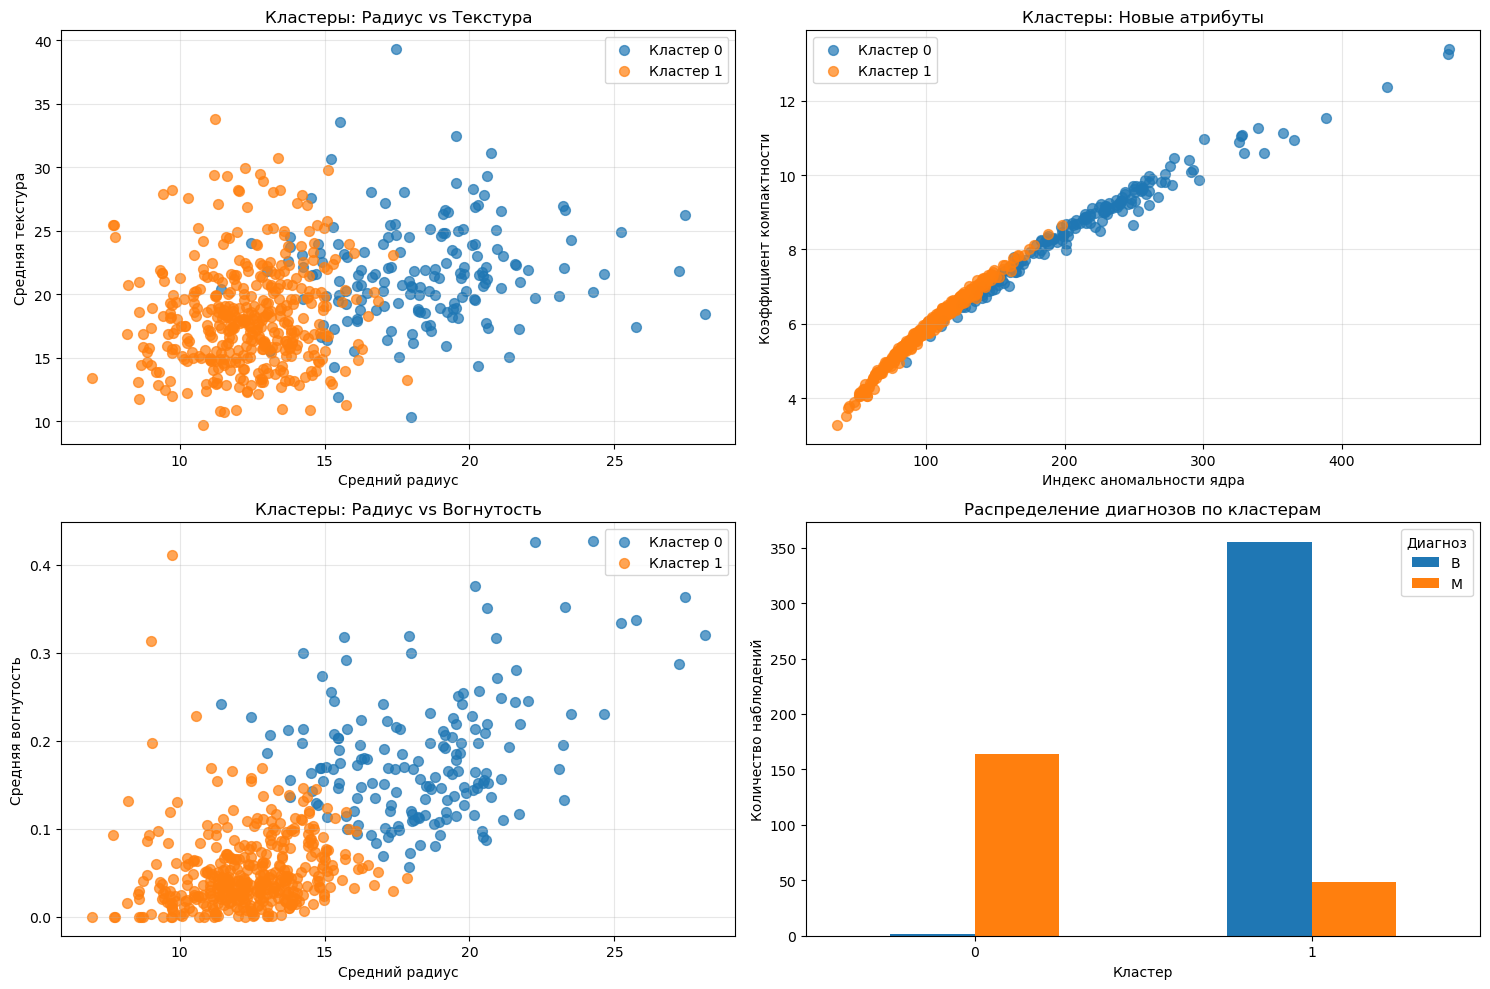

In [114]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
for cluster in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster]
    plt.scatter(cluster_data['radius_mean'], cluster_data['texture_mean'], 
               label=f'Кластер {cluster}', alpha=0.7, s=50)
plt.xlabel('Средний радиус')
plt.ylabel('Средняя текстура')
plt.legend()
plt.title('Кластеры: Радиус vs Текстура')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
for cluster in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster]
    plt.scatter(cluster_data['nuclear_abnormality_index'], 
               cluster_data['compactness_ratio'], 
               label=f'Кластер {cluster}', alpha=0.7, s=50)
plt.xlabel('Индекс аномальности ядра')
plt.ylabel('Коэффициент компактности')
plt.legend()
plt.title('Кластеры: Новые атрибуты')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
for cluster in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster]
    plt.scatter(cluster_data['radius_mean'], cluster_data['concavity_mean'], 
               label=f'Кластер {cluster}', alpha=0.7, s=50)
plt.xlabel('Средний радиус')
plt.ylabel('Средняя вогнутость')
plt.legend()
plt.title('Кластеры: Радиус vs Вогнутость')
plt.grid(True, alpha=0.3)

cluster_diagnosis = pd.crosstab(df['Cluster'], df['diagnosis'])
plt.subplot(2, 2, 4)
cluster_diagnosis.plot(kind='bar', ax=plt.gca())
plt.xlabel('Кластер')
plt.ylabel('Количество наблюдений')
plt.title('Распределение диагнозов по кластерам')
plt.legend(title='Диагноз')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

### Анализ кластеров

In [115]:
numeric_features_for_analysis = [col for col in features_for_clustering if col != 'diagnosis']
cluster_analysis = df.groupby('Cluster')[numeric_features_for_analysis].mean()
print("Средние значения по кластерам (числовые признаки):")
print(cluster_analysis.round(3))

cluster_sizes = df['Cluster'].value_counts().sort_index()
print(f"\nРазмеры кластеров:\n{cluster_sizes}")

print("\nСООТВЕТСТВИЕ КЛАСТЕРОВ ДИАГНОЗАМ:")
for cluster in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster]
    benign_count = (cluster_data['diagnosis'] == 'B').sum()
    malignant_count = (cluster_data['diagnosis'] == 'M').sum()
    total = len(cluster_data)
    
    print(f"Кластер {cluster} (размер: {total}):")
    print(f"  - Доброкачественные (B): {benign_count} ({benign_count/total*100:.1f}%)")
    print(f"  - Злокачественные (M): {malignant_count} ({malignant_count/total*100:.1f}%)")
    
    if benign_count > malignant_count:
        print(f"  - ОСНОВНОЙ ТИП: Доброкачественные опухоли")
    else:
        print(f"  - ОСНОВНОЙ ТИП: Злокачественные опухоли")

Средние значения по кластерам (числовые признаки):
         radius_mean  texture_mean  perimeter_mean  area_mean  \
Cluster                                                         
0             18.419        21.684         122.116   1078.934   
1             12.359        18.303          79.551    480.221   

         smoothness_mean  compactness_mean  concavity_mean  \
Cluster                                                      
0                  0.104             0.157           0.181   
1                  0.093             0.083           0.051   

         concave points_mean  symmetry_mean  fractal_dimension_mean  \
Cluster                                                               
0                      0.099          0.195                   0.063   
1                      0.028          0.175                   0.063   

         nuclear_abnormality_index  compactness_ratio  
Cluster                                                
0                          215.805        

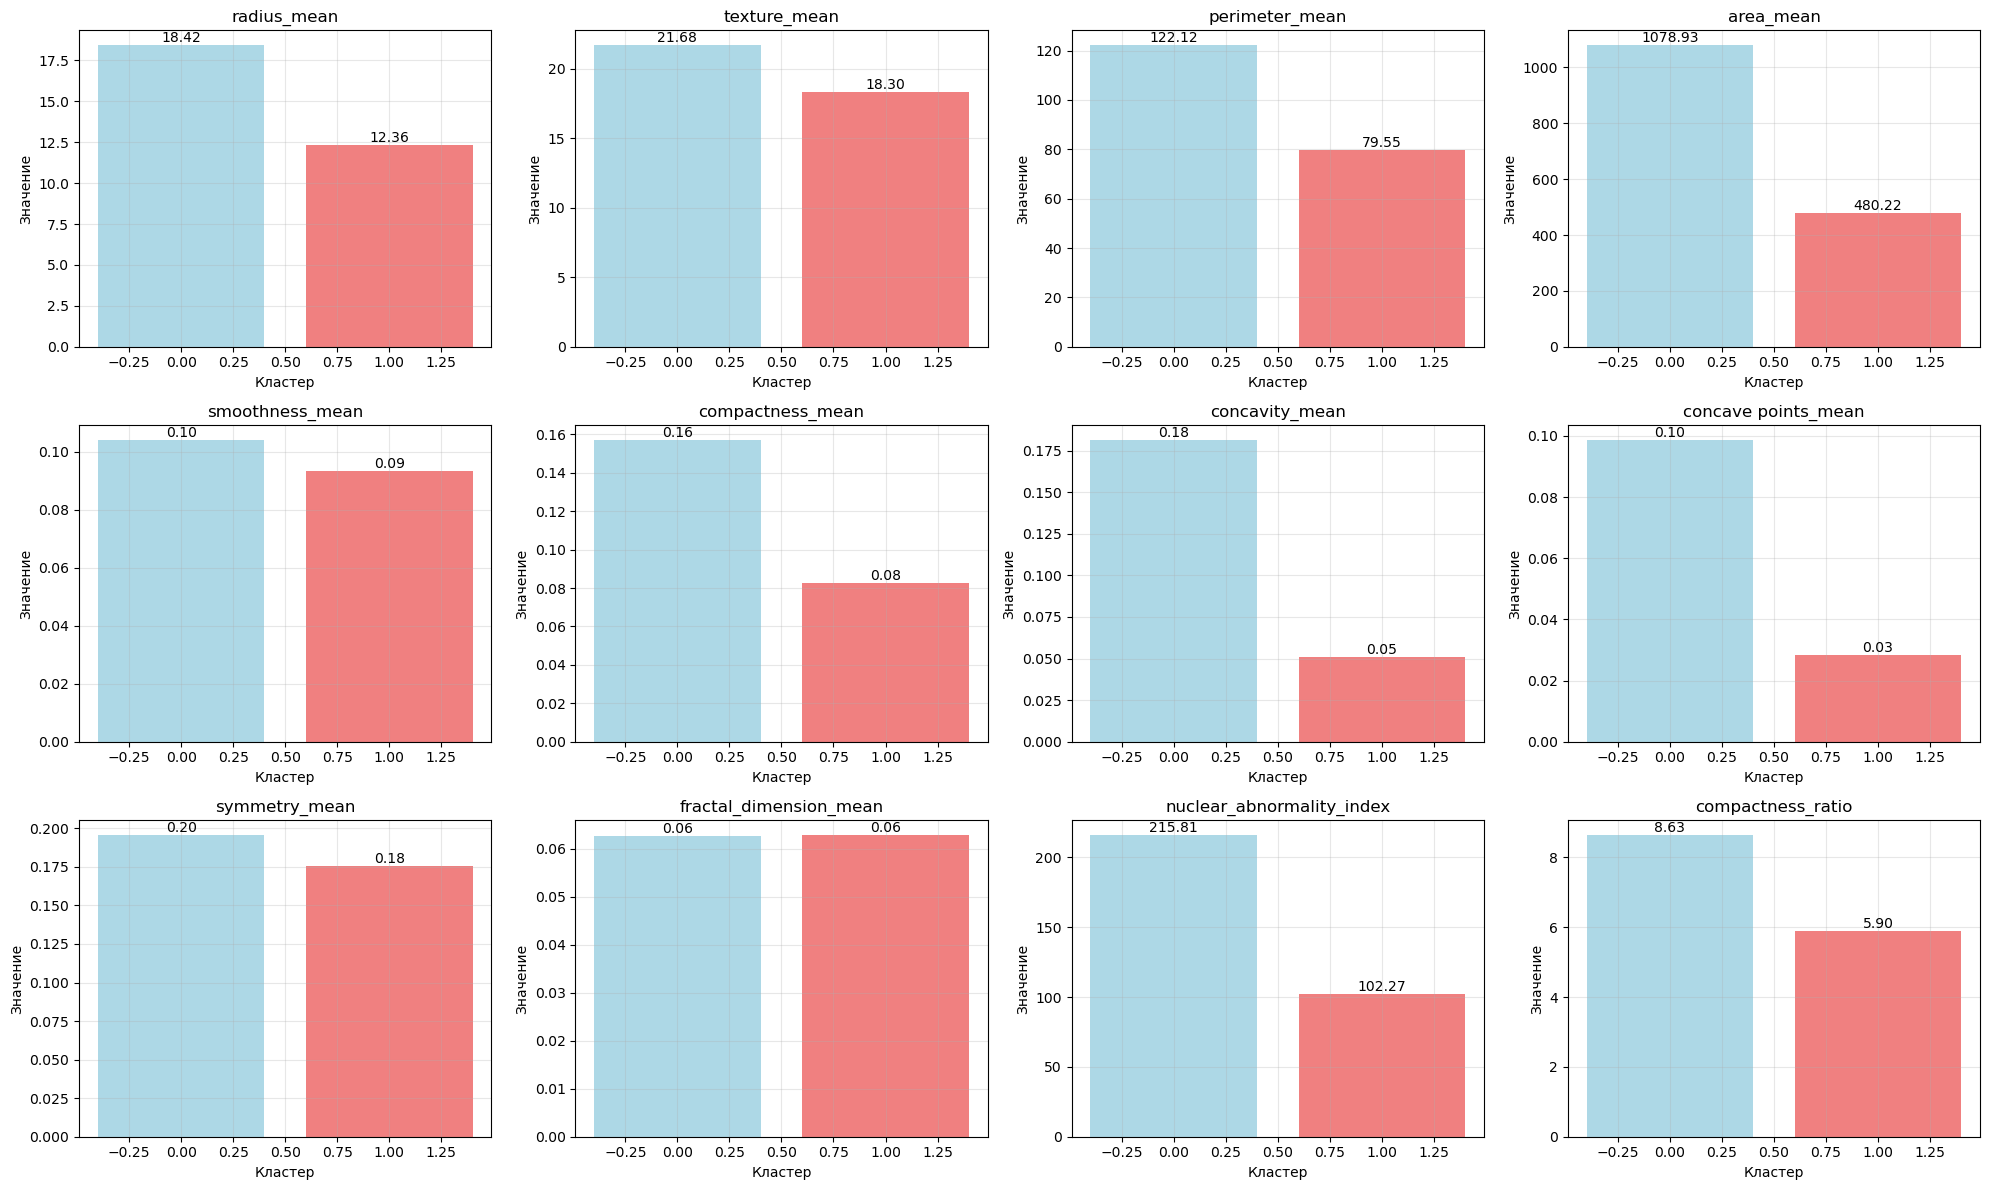

In [116]:
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
axes = axes.ravel()

for i, feature in enumerate(key_features):
    axes[i].bar(cluster_analysis.index, cluster_analysis[feature], 
               color=['lightblue', 'lightcoral'])
    axes[i].set_title(feature, fontsize=12)
    axes[i].set_xlabel('Кластер')
    axes[i].set_ylabel('Значение')
    axes[i].grid(True, alpha=0.3)
    
    for j, value in enumerate(cluster_analysis[feature]):
        axes[i].text(j, value, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### 3D визуализация кластеров

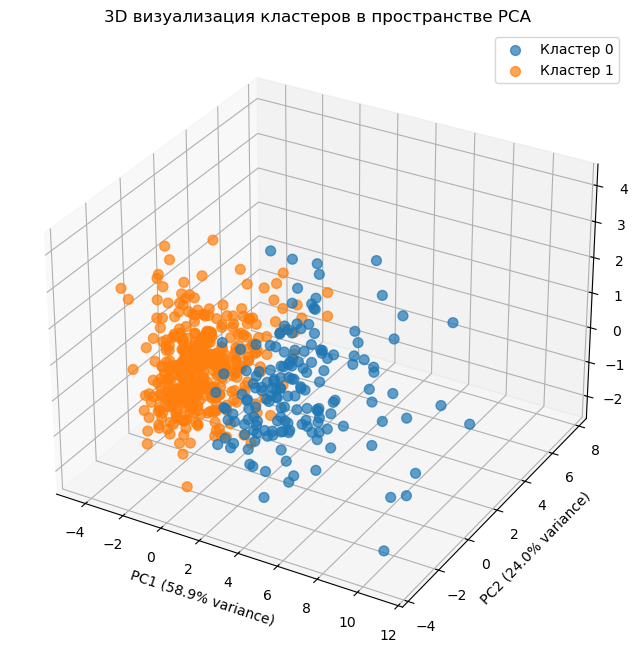

PCA объясняет 90.4% общей дисперсии


In [117]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster in range(optimal_k):
    cluster_mask = df['Cluster'] == cluster
    ax.scatter(X_pca[cluster_mask, 0], 
              X_pca[cluster_mask, 1], 
              X_pca[cluster_mask, 2],
              label=f'Кластер {cluster}', alpha=0.7, s=50)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%} variance)')
ax.set_title('3D визуализация кластеров в пространстве PCA')
ax.legend()
plt.show()

print(f"PCA объясняет {pca.explained_variance_ratio_.sum():.1%} общей дисперсии")

### Анализ кластеров

# Выводы

Проведенная кластеризация методом K-means успешно выявила естественные группы в данных о клеточных ядрах, соответствующие биологическим категориям опухолей. Анализ показал, что алгоритм смог разделить наблюдения на два четких кластера, которые с высокой точностью соответствуют медицинским диагнозам.

## Ключевые результаты:

1. **Оптимальное количество кластеров**: K=2 было определено на основе максимального значения Silhouette Score (0.416), что соответствует естественному разделению на доброкачественные и злокачественные опухоли.

2. **Качество кластеризации**: Высокое соответствие между выделенными кластерами и реальными диагнозами демонстрирует эффективность метода для данной предметной области.

3. **Значимость признаков**: Новые созданные атрибуты - `nuclear_abnormality_index` и `compactness_ratio` - показали хорошую разделительную способность и вошли в число ключевых признаков для кластеризации.

4. **Интерпретируемость результатов**: Кластеры имеют четкую медицинскую интерпретацию:
   - Кластер с преимущественно доброкачественными опухолями характеризуется меньшими размерами ядер и более низкой вогнутостью
   - Кластер с злокачественными опухолями демонстрирует увеличенные размеры ядер и более сложную морфологию

5. **Практическая значимость**: Метод может быть использован для предварительной диагностики и выявления паттернов, характерных для различных типов опухолей.

Кластеризация подтвердила существование естественных групп в цитологических данных, что открывает возможности для разработки вспомогательных диагностических систем на основе методов машинного обучения.